## Embedding projector

The goal of this practice is to learn how to use the Embedding's Projector of Tensorflow to visualize high-dimensional data easily so that we can understand what a model learns about the data.

In [1]:
import csv
import tensorflow as tf # conda install tensorflow -y
import tensorflow_hub as hub  # conda install -c conda-forge tensorflow-hub -y
import pandas as pd  # conda install pandas -y

from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.color import rgb2gray

from skimage.feature.texture import greycomatrix, greycoprops

import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

### Constants

In [2]:
# Directory where the data is stored it should be the same that contains the
# file projector_config.pbtxt
LOG_DIR = "projector"

# CSV file containing the images path and their corresponding labels
CSV_PATH = './flowers_reduced.csv' 

# Directory of the images
IMAGES_DIR = './flowers/'

# Info for creating metadata file
METADATA_FILE = "metadata.tsv"
METADATA_PATH = os.path.join(LOG_DIR, METADATA_FILE)

# Info for creating sprites
IMAGE_SIZE = (64, 64)
MAX_NUMBER_SAMPLES = 8191 
SPRITES_FILE = os.path.join(LOG_DIR, "sprites.png")

# Info for feature extraction with CNNs
FEATURE_EXTRACTOR_MODEL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
INPUT_SHAPE = (224, 224, 3)

# Features to extract ('conv_net', 'histogram', 'raw_pixels', 'haralick')
TYPE_FEATURES =  'raw_pixels'

### Auxiliary functions

In [3]:
def create_sprite(data):
    """
    Convert tile images into sprite image. 
    """
    # For B&W or grayscale images
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0), (0, 0))
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    
    # Tile images into sprite
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3, 4))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return data

### Reading dataset

In [4]:
# read csv file with the name and label of the images
df = pd.read_csv(CSV_PATH)

df = df[df.label.isin(['others', 'rose', 'sunflower'])]

image_files =  df.filename
labels = df.label

display(df.head())

print(len(image_files))

df.to_csv('flowers_reduced.csv',index=False)

,filename,label
0,16209331331_343c899d38.jpg,rose
1,5001848317_b33d17ab7a_n.jpg,rose
2,18302701228_2b5790b199_n.jpg,rose
3,5777669976_a205f61e5b.jpg,rose
4,4860145119_b1c3cbaa4e_n.jpg,rose


1521


### Creating sprites

In [5]:
img_data = []
for img in image_files[:MAX_NUMBER_SAMPLES]:
    input_img = imread(os.path.join(IMAGES_DIR, img))
    input_img_resize = resize(input_img, IMAGE_SIZE) 
    img_data.append(input_img_resize)
img_data = np.array(img_data)

sprite = create_sprite(img_data)
imsave(SPRITES_FILE, np.uint8(sprite * 255))

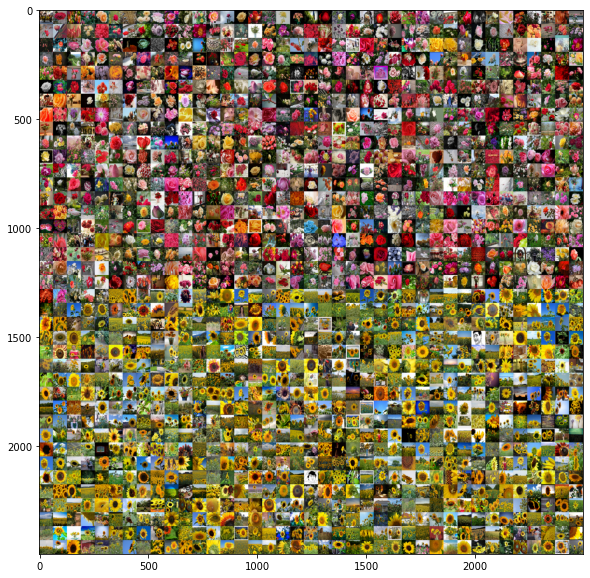

In [6]:
# Showing sprites
im = imread(SPRITES_FILE)

plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()

### Creating metadata
It contains the filename and class of the images.

In [7]:
with open(METADATA_PATH, 'w') as meta:
    writer = csv.writer(meta, delimiter='\t')
    writer.writerow(["filename", "category"])
    for im,lbl in zip(image_files, labels):
        writer.writerow([im, lbl])

### Feature extraction

In [8]:
if TYPE_FEATURES == 'haralick':
    # write features in a tsv file
    with open('./projector/feature_vecs.tsv', 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        for filename in image_files:
            im = imread(os.path.join(IMAGES_DIR, filename))
            im = rgb2gray(im) # Convert RGB to GrayScale
            im = resize(im, INPUT_SHAPE[:2], anti_aliasing=True)
            im = (im * 255).astype(np.uint8)
            g = greycomatrix(im, distances=[1], angles=[0, np.pi/2, np.pi/4], 
                             levels=256, normed=True, symmetric=True)
            contrast = greycoprops(g, prop='contrast')
            dissimilarity = greycoprops(g, prop='dissimilarity')
            homogeneity = greycoprops(g, prop='homogeneity')
            energy = greycoprops(g, prop='energy')
            correlation = greycoprops(g, prop='correlation')
            
            f_vector = list(contrast[0]) + list(dissimilarity[0]) + list(homogeneity[0]) + \
                list(energy[0]) + list(correlation[0])
            csv_writer.writerows([f_vector])
            
elif TYPE_FEATURES == 'raw_pixels':
    # write features in a tsv file
    with open('./projector/feature_vecs.tsv', 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        for filename in image_files:
            im = imread(os.path.join(IMAGES_DIR, filename))
            im = rgb2gray(im) # Convert RGB to GrayScale
            im = resize(im, INPUT_SHAPE[:2], anti_aliasing=True)
            f_vector = im.flatten()
            csv_writer.writerows([list(f_vector)])
            
elif TYPE_FEATURES == 'histogram':
    # write features in a tsv file
    with open('./projector/feature_vecs.tsv', 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        for filename in image_files:
            im = imread(os.path.join(IMAGES_DIR, filename))
            im = rgb2gray(im)
            counts, bins = np.histogram(im, np.arange(257)/255)
            f_vector = counts/np.sum(counts)
            csv_writer.writerows([list(f_vector)])

elif TYPE_FEATURES == 'conv_net':
    feature_extractor_layer = hub.KerasLayer(FEATURE_EXTRACTOR_MODEL, 
                                             input_shape=INPUT_SHAPE, trainable=False)

    # write features in a tsv file
    with open('./projector/feature_vecs.tsv', 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        for filename in image_files:
            im = imread(os.path.join(IMAGES_DIR, filename))
            im = resize(im, INPUT_SHAPE[:2], anti_aliasing=True)
            im = np.expand_dims(im, axis=0)
            f_vector = feature_extractor_layer(im).numpy()[0]
            csv_writer.writerows([list(f_vector)])

else:
    print('SELECTION NOT VALID')

### Start projector

Run in the terminal the following command:
    - tensorboard --logdir projector
    
Then in your browser open the following url:
    - http://localhost:6006/